# Requirement 1 - Text classification

In [74]:
import numpy as np
import pandas as pd
import warnings
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [75]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [76]:
df = pd.read_csv('train.csv')

In [77]:
df.head()

,Id,Title,Content,Label
0,227464,"Netflix is coming to cable boxes, and Amazon i...",if you subscribe to one of three rinky-dink (...,Entertainment
1,244074,"Pharrell, Iranian President React to Tehran 'H...","pharrell, iranian president react to tehran '...",Entertainment
2,60707,Wildlife service seeks comments,the u.s. fish and wildlife service has reopen...,Technology
3,27883,Facebook teams up with Storyful to launch 'FB ...,the very nature of social media means it is o...,Technology
4,169596,Caesars plans US$880 mln New York casino,caesars plans us$880 mln new york casino jul ...,Business


In [78]:
df = df.drop(['Id'], axis = 1)

## Question 1a - Word Cloud

In [79]:
labels = df['Label'].unique()

In [80]:
print(labels)

array(['Entertainment', 'Technology', 'Business', 'Health'], dtype=object)

In [81]:
def generate_wordcloud(label, content=False):
    label_data = df[df['Label'] == label]
    wordcloud = WordCloud(stopwords=STOPWORDS, max_font_size=40, background_color='white')
    if content:
        wordcloud.generate(label_data['Content'].to_string(index=False))
        wordcloud.to_file('{}_Content.png'.format(label))
    else:
        wordcloud.generate(label_data['Title'].to_string(index=False))
        wordcloud.to_file('{}_Title.png'.format(label))
    plt.title(label + " ({})".format(len(label_data)))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    

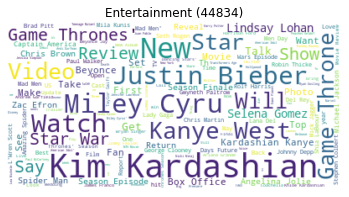

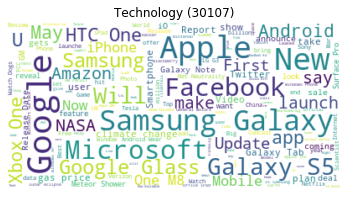

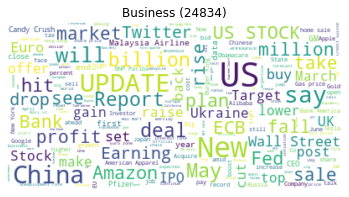

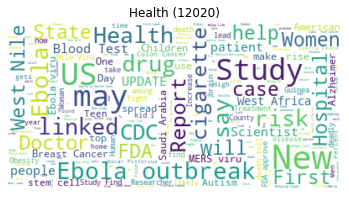

In [82]:
# Generate wordclouds based on title

for label in labels:
    generate_wordcloud(label)

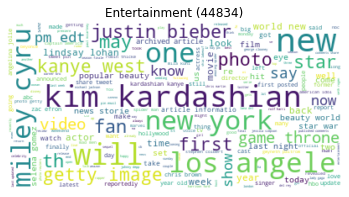

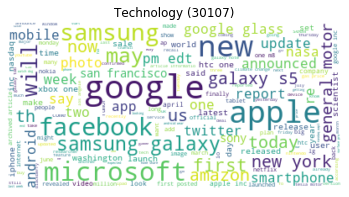

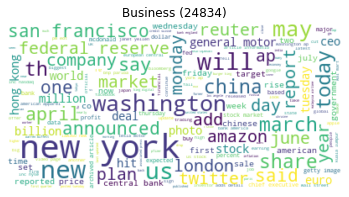

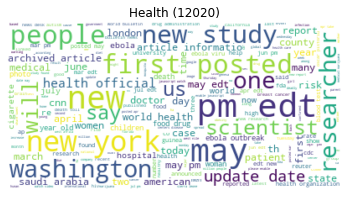

In [83]:
# Generate wordclouds based on content

for label in labels:
    generate_wordcloud(label, content=True)

## Question 1b - Classification Task

In [84]:
df.info()
len_start = len(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111795 entries, 0 to 111794
Data columns (total 3 columns):
Title      111795 non-null object
Content    111795 non-null object
Label      111795 non-null object
dtypes: object(3)
memory usage: 2.6+ MB


In [85]:
# Remove articles with duplicate content

df.drop_duplicates(subset='Content', keep='last', inplace=True)

In [86]:
df.info()
len_end = len(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109984 entries, 0 to 111794
Data columns (total 3 columns):
Title      109984 non-null object
Content    109984 non-null object
Label      109984 non-null object
dtypes: object(3)
memory usage: 3.4+ MB


In [89]:
# Display number of duplicates in the dataset

print('{} duplicate articles were removed from the dataset'
      .format(len_start - len_end))

1811 duplicate articles were removed from the dataset


In [92]:
# Relative frequency of labels

rel_freq = df.groupby('Label').Title.count() / len(df)
print(rel_freq)

Label
Business         0.221814
Entertainment    0.400213
Health           0.107779
Technology       0.270194
Name: Title, dtype: float64


Below, we can see that the classes are imbalanced.

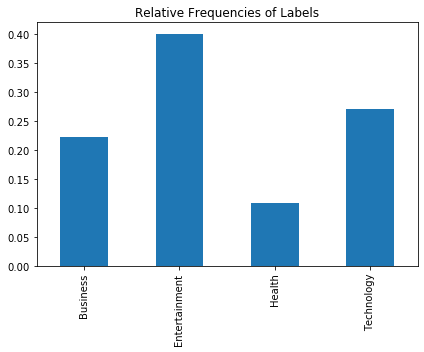

In [93]:
fig, ax = plt.subplots(figsize=(6, 5))
rel_freq.plot.bar(ax=ax)
ax.set_title('Relative Frequencies of Labels')
ax.set_xlabel('')
fig.tight_layout()
plt.savefig('label_freq.png')
plt.show()

In [94]:
def get_metrics(y_true, y_pred, metrics):
    metrics[0] += accuracy_score(y_true, y_pred)
    metrics[1] += precision_score(y_true, y_pred, average='macro')
    metrics[2] += recall_score(y_true, y_pred, average='macro')
    metrics[3] += f1_score(y_true, y_pred, average='macro')
    return metrics

In [114]:
def evaluate_classifier(clf, kfold, X, y, vectorizer, svd_enable=False):
    metrics = np.zeros(4)
    if svd_enable:
        svd = TruncatedSVD(n_components=300)
    start = timer()
    for train, cv in kfold.split(X, y):
        X_train, X_cv = X[train], X[cv]
        y_train, y_cv = y[train], y[cv]
        X_train_gen = [x for x in X_train]
        vectorizer.fit(X_train_gen)
        X_train_vec = vectorizer.transform(X_train_gen)
        if svd_enable:
            svd.fit(X_train_vec, y_train)
            X_train_vec = svd.transform(X_train_vec)
        clf.fit(X_train_vec, y_train)
        X_cv_gen = [x for x in X_cv]
        X_cv_vec = vectorizer.transform(X_cv_gen)
        if svd_enable:
            X_cv_vec = svd.transform(X_cv_vec)
        y_pred = clf.predict(X_cv_vec)
        metrics = get_metrics(y_cv, y_pred, metrics)
    dt = timer() - start
    metrics = metrics * 100 / 5
    print('Evaluation of classifier finished in {:.2f} s \n'
          'Average accuracy: {:.2f} % \n'
          'Average precision: {:.2f} % \n'
          'Average recall: {:.2f} % \n'
          'Average f-measure: {:.2f} % \n'
          .format(dt, metrics[0], metrics[1],
                  metrics[2], metrics[3]))

### Evaluation of SVM - Random Forests and BoW - SVD

In [115]:
# 5-Fold cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=56)

# Hashing vectorizer and stop words

stop_words = ENGLISH_STOP_WORDS
hashing = HashingVectorizer(n_features=2**18, stop_words=stop_words, lowercase=True)

# SVM and Random Forest

svm = LinearSVC()
random_forest = RandomForestClassifier(n_estimators=50, bootstrap=False, n_jobs=-1)

In [116]:
X = df['Content'].to_dense().values
y = df['Label'].to_dense().values

In [102]:
# SVM - BoW

evaluate_classifier(svm, kf, X, y, hashing)

Evaluation of classifier finished in 119.21 s 
Average accuracy: 97.04 % 
Average precision: 96.89 % 
Average recall: 96.65 % 
Average f-measure: 96.77 % 



In [105]:
# Random Forest - BoW

evaluate_classifier(random_forest, kf, X, y, hashing)

Evaluation of classifier finished in 506.77 s 
Average accuracy: 93.39 % 
Average precision: 93.72 % 
Average recall: 91.95 % 
Average f-measure: 92.78 % 



In [117]:
# SVM - SVD

evaluate_classifier(svm, kf, X, y, hashing, svd_enable=True)

Evaluation of classifier finished in 629.46 s 
Average accuracy: 93.02 % 
Average precision: 92.55 % 
Average recall: 91.97 % 
Average f-measure: 92.25 % 



In [118]:
# Random Forest - SVD

evaluate_classifier(random_forest, kf, X, y, hashing, svd_enable=True)

Evaluation of classifier finished in 715.30 s 
Average accuracy: 92.57 % 
Average precision: 92.74 % 
Average recall: 90.59 % 
Average f-measure: 91.57 % 



### Proposed method

In [113]:
# Classifiers

svm = LinearSVC(tol=1e-05, max_iter=1500)
ridge = RidgeClassifier(alpha=0.8, tol=1e-5)
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
pas_agr = PassiveAggressiveClassifier(early_stopping=True, 
                                      loss='squared_hinge', n_jobs=-1)
sgd = SGDClassifier(early_stopping=True, tol=1e-5, max_iter=1500,
                    loss='modified_huber', penalty='elasticnet',
                    l1_ratio=0.2, class_weight='balanced', n_jobs=-1)


In [109]:
# TF-IDF vectorizer

tfidf = TfidfVectorizer(stop_words=stop_words, min_df=3, 
                        max_df=0.5, ngram_range=(1, 2))

In [110]:
# Add titles to contents

df['Text'] = df['Title'] + ' ' + df['Content']
X_enh = df['Text'].to_dense().values
y = df['Label'].to_dense().values

In [111]:
X_train_cv, X_test, y_train_cv, y_test = train_test_split(X_enh, y, test_size=0.2)

In [112]:
# Random Forest classifier

evaluate_classifier(random_forest, kf, X_train_cv, y_train_cv, tfidf)

Evaluation of classifier finished in 481.26 s 
Average accuracy: 65.89 % 
Average precision: 64.31 % 
Average recall: 63.34 % 
Average f-measure: 63.22 % 



In [27]:
# SVM classifier

evaluate_classifier(svm, kf, X_train_cv, y_train_cv, tfidf)

Evaluation of classifier finished in 481.84 s 
Average accuracy: 97.65 % 
Average precision: 97.53 % 
Average recall: 97.32 % 
Average f-measure: 97.42 % 



In [28]:
# Ridge classifier

evaluate_classifier(ridge, kf, X_train_cv, y_train_cv, tfidf)

Evaluation of classifier finished in 813.22 s 
Average accuracy: 97.63 % 
Average precision: 97.55 % 
Average recall: 97.26 % 
Average f-measure: 97.41 % 



In [29]:
# kNN classifier

evaluate_classifier(knn, kf, X_train_cv, y_train_cv, tfidf)

Evaluation of classifier finished in 592.69 s 
Average accuracy: 97.29 % 
Average precision: 97.11 % 
Average recall: 96.95 % 
Average f-measure: 97.03 % 



In [30]:
# Passive agressive classifier

evaluate_classifier(pas_agr, kf, X_train_cv, y_train_cv, tfidf)

Evaluation of classifier finished in 429.34 s 
Average accuracy: 97.56 % 
Average precision: 97.44 % 
Average recall: 97.24 % 
Average f-measure: 97.34 % 



In [31]:
# Stochastic gradient descent classifier

evaluate_classifier(sgd, kf, X_train_cv, y_train_cv, tfidf)

Evaluation of classifier finished in 441.38 s 
Average accuracy: 96.45 % 
Average precision: 96.11 % 
Average recall: 96.10 % 
Average f-measure: 96.11 % 



In [56]:
# Voting ensemble of 3 classifiers

boost = VotingClassifier(estimators=[
                        ('svc', svm), ('ridge', ridge), ('knn', knn)],
                        voting='hard', n_jobs=-1)

In [57]:
# Voting classifier

evaluate_classifier(boost, kf, X_train_cv, y_train_cv, tfidf)

Evaluation of classifier finished in 1103.74 s 
Average accuracy: 97.72 % 
Average precision: 97.61 % 
Average recall: 97.38 % 
Average f-measure: 97.49 % 



In [58]:
# Evaluate ensemble on test set

metrics = np.zeros(4)
X_train_gen = [x for x in X_train_cv]
tfidf.fit(X_train_gen)
X_train_vec = tfidf.transform(X_train_gen)
boost.fit(X_train_vec, y_train_cv)
X_test_gen = [x for x in X_test]
X_test_vec = tfidf.transform(X_test_gen)
y_pred = boost.predict(X_test_vec)
metrics = get_metrics(y_test, y_pred, metrics)
metrics = metrics * 100
print('Evaluation of ensemble classifier on test set \n'
      'Average accuracy: {:.2f} % \n'
      'Average precision: {:.2f} % \n'
      'Average recall: {:.2f} % \n'
      'Average f-measure: {:.2f} % \n'
      .format(metrics[0], metrics[1],
              metrics[2], metrics[3]))

Evaluation of ensemble classifier on test set 
Average accuracy: 97.97 % 
Average precision: 97.93 % 
Average recall: 97.67 % 
Average f-measure: 97.80 % 



### Deliverable for competition

In [59]:
df_test = pd.read_csv('test_without_labels.csv')

Final Output

In [60]:
df_test['Text'] = df_test['Title'] + ' ' + df_test['Content']
X_final = df_test['Text'].to_dense().values

In [61]:
X_train_gen = [x for x in X_enh]
tfidf.fit(X_train_gen)
X_train_vec = tfidf.transform(X_train_gen)
boost.fit(X_train_vec, y)
X_test_gen = [x for x in X_final]
X_test_vec = tfidf.transform(X_test_gen)
y_pred = boost.predict(X_test_vec)

In [62]:
y_pred.shape

(47912,)

In [63]:
df_results = pd.DataFrame({'Id':df_test['Id'], 'Predicted':y_pred})

In [64]:
df_results.to_csv('testSet_categories.csv',index=False, header=True)